## Generating Benchmark Data for Wikipedia Dataset

The data is taken from the [Web Traffic Time Series Forecasting
](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/overview) challenge on Kaggle, a research competiton organized by Google ($25,000).

In [1]:
ROOT = "/Users/liaopeiyuan/Documents/"
data_dir = ROOT + "web-traffic-time-series-forecasting/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm

/opt/anaconda3/envs/test/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(data_dir + 'train_1.csv').fillna(0)
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Forecasting is done on a separate file. Here's what it looks like.

```python
import dask.dataframe as dd

ddf = dd.from_pandas(df, npartitions=10000)

forecast_horizon = 100

def predict(row):
    data = pd.DataFrame({'ds': (row.index)[1:][-forecast_horizon:], 'y':(row.values)[1:][-forecast_horizon:]})
    m = Prophet()
    m.fit(data)
    
    future = m.make_future_dataframe(periods=forecast_horizon)
    future.tail()
    forecast = m.predict(future)

    return row.Page, forecast[['yhat']][-forecast_horizon:].values.reshape(-1)
```

### Sanity check by plotting

In [23]:
import pickle
predictions = pickle.load(open(data_dir + 'wikipedia_time_series_prediction_raw/result.pkl', 'rb'))

SMAPE:  69.803


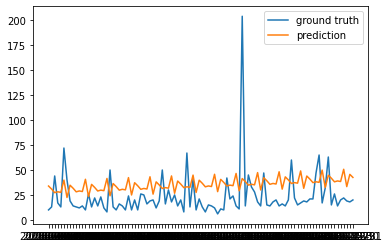

In [41]:
import seaborn as sns

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

pred = predictions[0][1]
index = list(df.columns)[1:][-100:]
gt = df.iloc[0,:].values[-100:]

sns.lineplot(x=index, y=gt, label='ground truth')
sns.lineplot(x=index, y=pred, label='prediction')

print("SMAPE: ", smape(gt, pred).round(3))

### Export trace for benchmarking 

In [51]:
time_index = index
disagg = []

for p, (i, g) in tqdm(zip(predictions, df.iterrows()), total = len(df)):
    assert(p[0] == g.Page)
    disagg.append((g.Page, p[1], g.values[-100:]))

100%|███████████████████████████████████████| 145063/145063 [00:11<00:00, 13174.18it/s]


In [52]:
disagg

[('2NE1_zh.wikipedia.org_all-access_spider',
  array([33.92989903, 30.86228545, 27.29467112, 28.16275953, 27.60019631,
         39.85633596, 22.47528773, 34.76547895, 31.69786537, 28.13025103,
         28.99833945, 28.43577623, 40.69191588, 23.31086765, 35.60105887,
         32.53344529, 28.96583095, 29.83391937, 29.27135615, 41.5274958 ,
         24.14644757, 36.43663879, 33.36902521, 29.80141087, 30.66949929,
         30.10693606, 42.36307572, 24.98202749, 37.2722187 , 34.20460513,
         30.63699079, 31.5050792 , 30.94251598, 43.19865564, 25.81760741,
         38.10779862, 35.04018505, 31.47257071, 32.34065912, 31.7780959 ,
         44.03423555, 26.65318732, 38.94337854, 35.87576497, 32.30815063,
         33.17623904, 32.61367582, 44.86981547, 27.48876724, 39.77895846,
         36.71134489, 33.14373055, 34.01181896, 33.44925574, 45.70539539,
         28.32434716, 40.61453838, 37.54692481, 33.97931047, 34.84739888,
         34.28483566, 46.54097531, 29.15992708, 41.4501183 , 38.382